In [1]:
#IPYNB For Optimizing KNN
#many of these libraries are probably not needed
import pandas as pd 
import numpy as np
import os
from skimage.feature import hog
import matplotlib.pyplot as plt
from KNN import knn_predict_L2, knn_predict_L1, knn_predict_Minkowski
from plotutils import plot_data, plot_surface
from knncrossval import KNN_cross_validate
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, f1_score, precision_score
from confusion_matrix import make_confusion_matrix
from skimage.feature import hog
import numpy as np
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
#cwd = os.getcwd() #if need the current directory 
df = pd.read_csv('digit-recognition/digit-recognition/train.csv')
df2 = pd.read_csv('digit-recognition/digit-recognition/test.csv')
#the shape of the dataframe is (38000, 785) meaning there are 38000 samples and 1 label with 784 features

In [ ]:
#turn the training dataframe into numpy array 
label_data_train = df.to_numpy()

#column vector for the labels (38000,)
label_train = label_data_train[:,0] 

#( 38000 x 784 matrix for the training data  )
data_train = label_data_train[:, 1:] 
print(label_train.shape)
print(data_train.shape)

#turn testing dataframe into numpy array 
label_data_test = df2.to_numpy()
label_test = label_data_test[:,0]
data_test = label_data_test[:,1:]

list_hog = []
list_hog1 = []
for sample in data_train:
    fd = hog(sample.reshape((28,28)), orientations=9, pixels_per_cell=(4,4),cells_per_block=(3,3),visualize=False ) #can probably optimize this
    list_hog.append(fd) #4x4 seems to be optimal 
hog_features_train = np.array(list_hog, 'float64')

#on testing data 
for sample in data_test:
    fd = hog(sample.reshape((28,28)), orientations=9, pixels_per_cell=(4,4), cells_per_block=(3,3),visualize=False )
    list_hog1.append(fd)
hog_features_test = np.array(list_hog1, 'float64')
data_train = hog_features_train
data_test = hog_features_test

(38000,)
(38000, 784)


In [5]:
# Determine our dataset size for cross validation and training
num_labels = len(np.unique(label_train))
num_cv_splits = 50
num_train_splits = 25 #int(num_cv_splits/2)
# Initialize variables here for convenient use throughout
k_value = [3, 4, 5, 6, 7, 8, 9]
num_folds = 4

CV Subset selection: 5


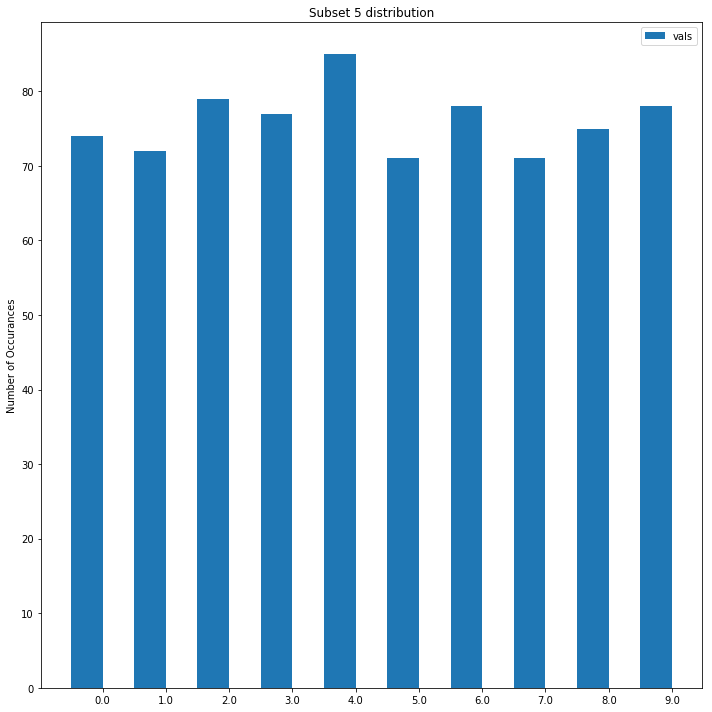

In [6]:
# We won't cross validation on the whole data set to save time. 
# Pick our subset by choosing the split with the most equal label distribution.

frequencies = np.zeros((num_cv_splits, num_labels, 2))
split_train_labels = np.split(label_train, num_cv_splits)

for i in range(len(split_train_labels)):
    (unique, counts) = np.unique(split_train_labels[i], return_counts=True)
    frequencies[i] = np.asarray((unique, counts)).T
    
variances = np.zeros(len(frequencies))

for i in range(len(frequencies)):
    labels = frequencies[i][:, 0]
    vals = frequencies[i][:, 1]
    variances[i] = np.var(vals)
    
cv_subset_selection = np.argmin(variances)
print("CV Subset selection: {0}".format(cv_subset_selection))

labels = frequencies[cv_subset_selection][:, 0]
vals = frequencies[cv_subset_selection][:, 1]

x = np.arange(len(labels))  # the label locations
fig, ax = plt.subplots()
rects1 = ax.bar(x - 0.25, vals, 0.5, label='vals')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Occurances')
ax.set_title('Subset {0} distribution'.format(cv_subset_selection))
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()
split_cv_data = np.split(data_train, num_cv_splits)[cv_subset_selection]
split_cv_labels = np.split(label_train, num_cv_splits)[cv_subset_selection]

Determined best parameters for Euclidean KNN: 5


Text(0.5,1,'Euclidean KNN Cross-Validation')

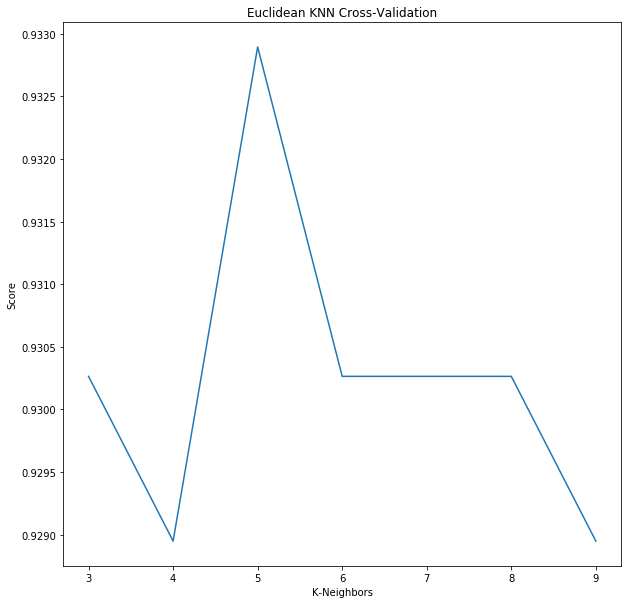

In [7]:
# Run cross-validation on Euclidean KNN to determine optimal k-value 

best_score = 0
k_scores = np.zeros(len(k_value))
for j in range(len(k_value)):
    cv_score = KNN_cross_validate(knn_predict_L2, split_cv_data, split_cv_labels, num_folds, k_value[j], 0)
    #do mean squared error plot?
    k_scores[j] = cv_score
    if cv_score > best_score:
        best_score = cv_score
        best_k = k_value[j]
print("Determined best parameters for Euclidean KNN: {0}".format(best_k))
plt.plot(k_value[:], k_scores)
plt.xlabel("K-Neighbors")
plt.ylabel("Score")
plt.title('Euclidean KNN Cross-Validation')

In [8]:
answers, count = knn_predict_L2(data_train, label_train, data_test, best_k, 0)
test_accuracy = np.mean(answers.ravel() == label_test)
print(test_accuracy * 100)

98.52499999999999


(4000,)


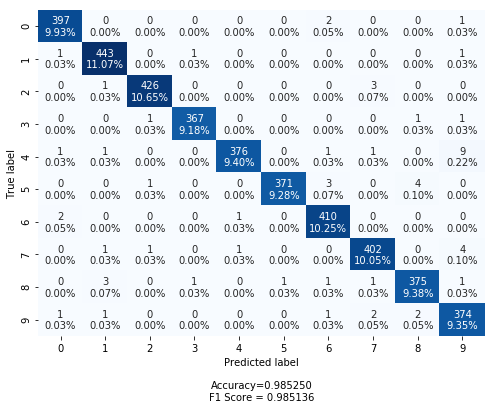

In [9]:
#Confusion Matrix
#https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
#code to create a confusion matrix using scikit-learn and seaborn 
print(label_test.shape)
cf_matrix = confusion_matrix(label_test, answers.ravel())
make_confusion_matrix(cf_matrix, label_test, answers.ravel(), figsize=(8,6), cbar=False)

Text(0.5,1,'L1 KNN Cross-Validation')

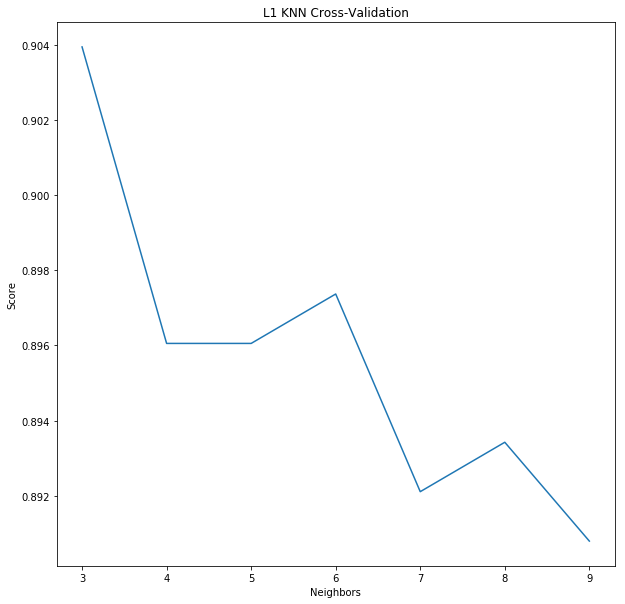

In [10]:
#Run cross-validation on L1 KNN to determine optimal k-value
best_score = 0
k_scores = np.zeros(len(k_value))
for j in range(len(k_value)):
    cv_score = KNN_cross_validate(knn_predict_L1, split_cv_data, split_cv_labels, num_folds, k_value[j], 0)
    #do mean squared error plot?
    k_scores[j] = cv_score
    if cv_score > best_score:
        best_score = cv_score
        best_k = k_value[j]
plt.plot(k_value[:], k_scores)
plt.xlabel("Neighbors")
plt.ylabel("Score")
plt.title('L1 KNN Cross-Validation')

In [11]:
answers, count = knn_predict_L1(data_train, label_train, data_test, best_k, 0)
test_accuracy = np.mean(answers.ravel() == label_test)
print(test_accuracy * 100)

98.225


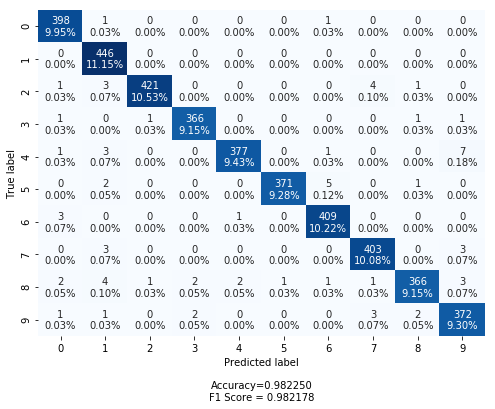

In [12]:
#Confusion Matrix
#https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
#code to create a confusion matrix using scikit-learn and seaborn 
cf_matrix = confusion_matrix(label_test, answers.ravel())
make_confusion_matrix(cf_matrix, label_test, answers.ravel(), figsize=(8,6), cbar=False)